# Atividade: CNNs para Classificação

Neste notebook, iremos preparar nosso próprio dataset e treinar um modelo de classificação de imagens.

## Preparando os dados

Os dados desta atividade serão baixados da internet. Utilizaremos para isso buscadores comuns. Em seguida, dividiremos em treinamento e validação.

In [1]:
!pip install icrawler

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [17]:
import os
import shutil
import random
from icrawler.builtin import GoogleImageCrawler, BingImageCrawler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
NUM_EPOCAS = 50 # Número de épocas de treinamento
LEARNING_RATE = 0.001 # Taxa de aprendizado do otimizador

### Adquirindo as Imagens

Utilizaremos o iCrawler para baixar imagens em buscadores através de termos especificados. Defina sua lista de classes.

In [5]:
def download_images(keyword, folder, n_total=100):
    os.makedirs(folder, exist_ok=True)
    downloaded = len(os.listdir(folder))
    remaining = n_total - downloaded

    while downloaded < n_total:
        crawler = BingImageCrawler(storage={'root_dir': folder})
        crawler.crawl(keyword=keyword, max_num=remaining, file_idx_offset=downloaded)
        downloaded = len(os.listdir(folder))
        remaining = n_total - downloaded
        print(f"Downloaded {downloaded}/{n_total}")

    print("Download complete!")

In [ ]:
# Classes escolhidas para as imagens
search_terms = {
    "vader": "darth vader",
    "yoda": "mestre yoda",
    "luke": "luke skywalker",
    "stormtrooper": "stormtrooper"
}

for label, term in search_terms.items():
    download_images(term, f"data/star_wars/{label}", n_total=100)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Treinamento e Validação

Dividiremos as imagens baixadas nas pastas `train` e `val`. Defina uma porcentagem.

In [8]:
# Divisão dos dados em: 70% para treinamento e 30% para validação
def split_train_val(root_dir, train_ratio=0.7, seed=42):
    random.seed(seed)

    train_dir = root_dir + "_split/train"
    val_dir = root_dir + "_split/val"

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [os.path.join(class_path, f) for f in os.listdir(class_path)]
        images = [f for f in images if os.path.isfile(f)]
        random.shuffle(images)

        n_train = int(len(images) * train_ratio)

        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        for img in images[:n_train]:
            shutil.copy(img, os.path.join(train_class_dir, os.path.basename(img)))
        for img in images[n_train:]:
            shutil.copy(img, os.path.join(val_class_dir, os.path.basename(img)))

        print(f"{class_name}: {n_train} train, {len(images)-n_train} val")

In [9]:
print("Dados de treinamento e validação")
split_train_val("data/star_wars", train_ratio=0.7, seed=42)

luke: 70 train, 30 val
yoda: 70 train, 30 val
stormtrooper: 70 train, 30 val
vader: 70 train, 30 val


## Dataset

Implemente um Dataset PyTorch que carregue as imagens baixadas com suas respectivas classes. Aplique data augmentation e carregue em batches.

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [11]:
dataset_path = "/content/data/star_wars_split" # Caminho dos dados de treinamento e validação

# Carregamento das imagens
dataset_train = datasets.ImageFolder(
    root=dataset_path + "/train",
    transform=train_transform
)

dataset_val = datasets.ImageFolder(
    root=dataset_path + "/val",
    transform=val_transform
)

# Dataloader de treinamento
dataloader_train = DataLoader(
    dataset_train,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Dataloader de validação
dataloader_val = DataLoader(
    dataset_val,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


In [12]:
print("Visualização dos dataloaders de treinamento e validação")

images, labels = next(iter(dataloader_train))
print("Treino:", images.shape, labels)

images, labels = next(iter(dataloader_val))
print("Validação:", images.shape, labels)


Treino: torch.Size([16, 3, 224, 224]) tensor([3, 3, 2, 1, 2, 3, 3, 3, 1, 1, 2, 2, 0, 3, 3, 1])
Validação: torch.Size([16, 3, 224, 224]) tensor([3, 0, 0, 3, 2, 2, 1, 0, 1, 1, 1, 3, 3, 2, 1, 1])


In [15]:
# Se disponível seleciona gpu senão cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Definição do Modelo

Defina aqui o modelo que será utilizado, sendo implementação própria ou um modelo pré-treinado. Teste diversas arquiteturas diferentes e verifique qual delas tem melhor desempenho em validação.

In [13]:
# Classe que define uma CNN para extração de features e uma MLP para classificação
class ClassifierCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.MaxPool2d(2, 2),   # 224 -> 112

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.MaxPool2d(2, 2),   # 112 -> 56

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.MaxPool2d(2, 2),   # 56 -> 28
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)     # passa pelo extrator
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)   # classificador
        return x

In [16]:
# Instância do modelo
model = ClassifierCNN().to(device)

## Treinamento

Defina a função de custo e o otimizador do modelo. Em seguida, implemente o código de treinamento e treine-o. Ao final, exiba as curvas de treinamento e validação para a loss e a acurácia.

### Função de perda e otimizador

In [18]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Loop de treinamento

In [19]:
# Vetores para armazenar métricas de perda e acurária do treinamento e validação
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(NUM_EPOCAS):

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in dataloader_train:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # acurácia
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(dataloader_train)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validação
    model.eval()
    running_loss_val = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in dataloader_val:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)

            running_loss_val += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_loss_val / len(dataloader_val)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{NUM_EPOCAS}] -> '
          f'Train Loss: {train_loss:.3f}, Train Acc: {train_accuracy:.2f}% | '
          f'Val Loss: {val_loss:.3f}, Val Acc: {val_accuracy:.2f}%')


Epoch [1/50] -> Train Loss: 1.940, Train Acc: 25.71% | Val Loss: 1.352, Val Acc: 36.67%
Epoch [2/50] -> Train Loss: 1.316, Train Acc: 33.57% | Val Loss: 1.152, Val Acc: 57.50%
Epoch [3/50] -> Train Loss: 1.265, Train Acc: 46.07% | Val Loss: 1.104, Val Acc: 60.00%
Epoch [4/50] -> Train Loss: 1.159, Train Acc: 53.57% | Val Loss: 0.874, Val Acc: 72.50%
Epoch [5/50] -> Train Loss: 1.027, Train Acc: 64.29% | Val Loss: 0.992, Val Acc: 58.33%
Epoch [6/50] -> Train Loss: 0.898, Train Acc: 65.00% | Val Loss: 0.872, Val Acc: 62.50%
Epoch [7/50] -> Train Loss: 0.871, Train Acc: 72.14% | Val Loss: 0.680, Val Acc: 72.50%
Epoch [8/50] -> Train Loss: 0.723, Train Acc: 73.93% | Val Loss: 0.872, Val Acc: 71.67%
Epoch [9/50] -> Train Loss: 0.652, Train Acc: 78.93% | Val Loss: 0.650, Val Acc: 75.00%
Epoch [10/50] -> Train Loss: 0.616, Train Acc: 78.93% | Val Loss: 0.527, Val Acc: 70.83%
Epoch [11/50] -> Train Loss: 0.535, Train Acc: 78.93% | Val Loss: 0.601, Val Acc: 79.17%
Epoch [12/50] -> Train Loss: 0

### Curvas de treinamento e validação para a perda e acurácia

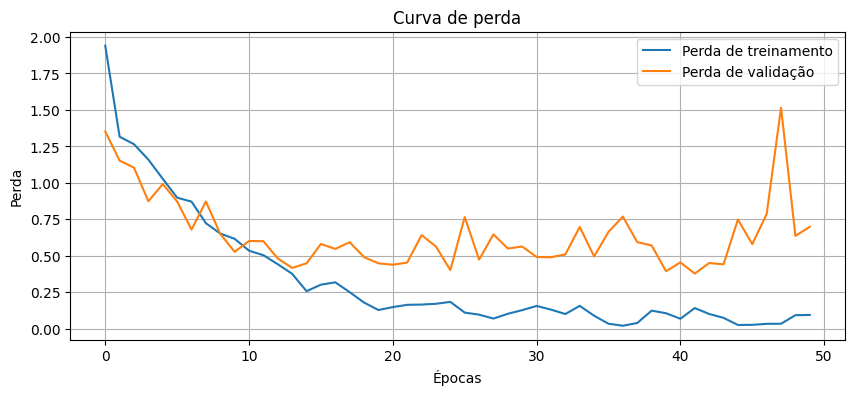

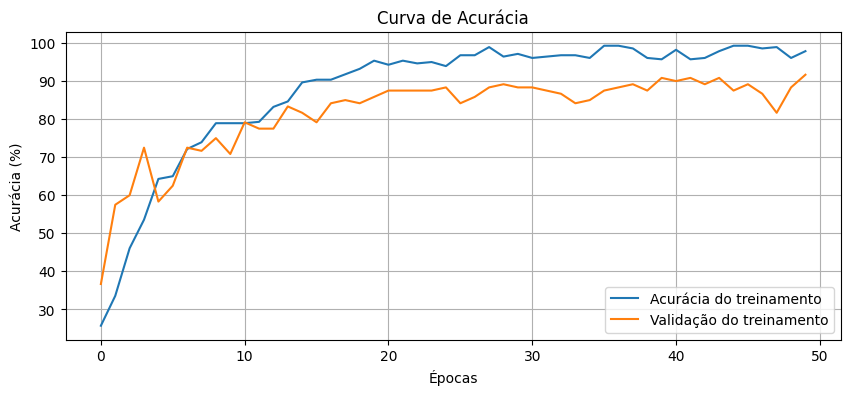

In [25]:
# Perda
plt.figure(figsize=(10,4))
plt.plot(train_losses, label="Perda de treinamento")
plt.plot(val_losses, label="Perda de validação")
plt.title("Curva de perda")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.legend()
plt.grid()
plt.show()

# Acurácia
plt.figure(figsize=(10,4))
plt.plot(train_accuracies, label="Acurácia do treinamento")
plt.plot(val_accuracies, label="Validação do treinamento")
plt.title("Curva de Acurácia")
plt.xlabel("Épocas")
plt.ylabel("Acurácia (%)")
plt.legend()
plt.grid()
plt.show()


## Inferência

Calcule algumas métricas como acurácia, matriz de confusão, etc. Em seguida, teste o modelo em novas imagens das classes correspondentes mas de outras fontes (outro buscador, fotos próprias, etc).

### Método para carregar imagem e testar classificação do modelo

In [21]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class_names = ['luke', 'stormtrooper', 'vader', 'yoda']

def predict_image(image_path, model, device):
    # Carregar imagem
    img = Image.open(image_path).convert("RGB")

    # Aplicar transform
    tensor = val_transform(img).unsqueeze(0).to(device)

    # Modelo em modo de avaliação
    model.eval()
    with torch.no_grad():
        output = model(tensor)
        _, predicted = torch.max(output, 1)

    return class_names[predicted.item()]


In [26]:
# Caminho da pasta onde foram baixadas as imagens
folder = "/content/data/test"

print("Teste do modelo com imagens baixadas manualmente no Google")
for filename in os.listdir(folder):
    path = os.path.join(folder, filename)
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        pred = predict_image(path, model, device)
        print(filename, "->", pred)

Teste do modelo com imagens baixadas manualmente no Google
yoda.jpg -> luke
stormtrooper.png -> stormtrooper
teste.jpg -> vader
